# W2V
- 기존 통계 기법의 단점을 커버하는 추론기법
- 맥락 정보를 입력받아 각 단어의 출현 확률을 구함
- 학습 결과로 얻어진 `가중치`를 `단어의 분산 표현`으로 이용

![process](img/process.png)

|특징| 통계 기법| 추론기법 |
|:--------|:--------|:--------|
|학습| 말뭉치 전체 통계로 1회 학습 | 말뭉치의 일부를 여러번 학습 |
|새로운 단어 추가| 처음부터 다시 계산 | 추가 학습 가능 |
|정밀도| 단어의 유사성 |유사성 + 단어 사이의 패턴|

## CBOW vs Skip-gram
- 주변 맥락을 통해 단어를 예측 vs 단어를 통해 주변 맥락을 예측
- Skip-gram이 학습에 더 오랜 시간이 걸리지만 성능이 더 좋음

![cbow_vs_skipgram](img/cbow_vs_skipgram.png)

### CBOW
![cbow](img/cbow.png)


### Skip-gram
![cbow](img/skipgram.png)

### W2V의 결과?
- 맥락을 통해 나올 단어를 예측
- $W_{in}$, $W_{out}$ 두 종류의 Weight 존재
- $W_{in}$는 각 행이 각 단어의 분산 표현
- $W_{out}$는 각 열이 각 단어의 분산 표현
- 보통 $W_{in}$이 단어의 분산 표현을 잘 나타냄

![weight](img/weight.png)


## 구현
- 순전파, 역전파를 위해 정형화된 클래스를 이용

### 입력층 - 은닉층
- 단어를 적절한 고정된 입력으로 변환해야 학습이 가능
- One-hot vector 사용
- 은닉층의 차원이 전체 단어의 차원보다 작아야 차원을 감소하며 단어의 분산을 얻음

![input1](img/input1.png)

![inpit3](img/input3.png)

![inpit4](img/input4.png)

In [1]:
#!pip install numpy

In [2]:
#!pip install matplotlib

In [3]:
import numpy as np

In [4]:
c = np.array([1, 0, 0, 0, 0, 0, 0])
W = np.random.randn(7, 3)
h = np.matmul(c, W)

print("c: 각 단어의 원핫 벡터")
print(c, "\n")

print("W: 모든 단어를 나타내는 가중치")
print(W, "\n")

print("h: 은닉층 결과(특정 단어의 가중치 추출)")
print(h)

c: 각 단어의 원핫 벡터
[1 0 0 0 0 0 0] 

W: 모든 단어를 나타내는 가중치
[[ 1.22726987 -0.23983259 -0.27001615]
 [-1.26962716 -0.02883663 -0.24745658]
 [-1.03172602 -0.48852003 -1.88793073]
 [ 0.20329668  0.60161961 -0.04102961]
 [ 0.93982955  0.73529502 -0.72946023]
 [ 0.7309136  -0.21717332  1.04162089]
 [ 0.01460214 -1.22850188 -0.39711563]] 

h: 은닉층 결과(특정 단어의 가중치 추출)
[ 1.22726987 -0.23983259 -0.27001615]


### MatMul 계층 구현

In [5]:
class MatMul:
    def __init__(self, W):
        self.params = [W]  # 파라미터가 여러개일 수 있어서 리스트 사용
        self.grads = [np.zeros_like(W)]  # 역전파된 결과를 저장하기 위해 사용
        self.x = None  # 역전파시 필요

    # 순전파
    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    # 역전파
    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW  # mutable한 데이터이기 때문에 같은 메모리를 가리키지 않도록 함
        return dx

### MatMul 확인
![cbow](img/skipgram.png)

In [6]:
# 샘플 맥락 데이터
c = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)

# 계층 생성
in_layer = MatMul(W_in)

# 순전파
h = in_layer.forward(c)
print(h)

[[-0.71982374  0.14366256  0.40786473]]


### 은닉층 - 출력층
- 은닉층 - 출력층 사이의 $W_{out}$은 $W_{in}$를 전치한 shape을 가짐

In [7]:
# 샘플 맥락 데이터
c = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h = in_layer.forward(c)
s = out_layer.forward(h)
print(s)

[[ 0.43164536  0.04615149 -0.23287912  0.592936    0.1409245   0.2722689
   0.78716573]]


### 출력층 - 확률(Softmax)
- 출력 결과를 확률로 만들기 위해 Softmax를 이용
- 오차를 구하기 위해 cross-entropy를 이용하며, 보통 합쳐서 Softmax with Loss 계층 사용
- 추론시에는 Softmax만 사용해야 함(주의)
- 오차는 출력과 정답의 차이

![softmax_with_loss](img/softmax_with_loss.png)

In [8]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    # 소프트맥스
    def softmax(self, x):
        if x.ndim == 2:
            x = x - x.max(axis=1, keepdims=True)
            x = np.exp(x)
            x /= x.sum(axis=1, keepdims=True)
        elif x.ndim == 1:
            x = x - np.max(x)
            x = np.exp(x) / np.sum(np.exp(x))

        return x

    # 크로스 엔트로피
    def cross_entropy_error(self, y, t):
        if y.ndim == 1:
            t = t.reshape(1, t.size)
            y = y.reshape(1, y.size)

        # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
        if t.size == y.size:
            t = t.argmax(axis=1)

        batch_size = y.shape[0]

        return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

    def forward(self, x, t):
        self.t = t
        self.y = self.softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = self.cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [9]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None


In [10]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

| 에폭 1 |  반복 1 / 476 | 시간 2[s] | 손실 17.83
| 에폭 1 |  반복 21 / 476 | 시간 3[s] | 손실 17.83
| 에폭 1 |  반복 41 / 476 | 시간 5[s] | 손실 17.83
| 에폭 1 |  반복 61 / 476 | 시간 6[s] | 손실 17.83
| 에폭 1 |  반복 81 / 476 | 시간 8[s] | 손실 17.83
| 에폭 1 |  반복 101 / 476 | 시간 9[s] | 손실 17.83
| 에폭 1 |  반복 121 / 476 | 시간 11[s] | 손실 17.81
| 에폭 1 |  반복 141 / 476 | 시간 12[s] | 손실 17.79
| 에폭 1 |  반복 161 / 476 | 시간 14[s] | 손실 17.75
| 에폭 1 |  반복 181 / 476 | 시간 16[s] | 손실 17.71
| 에폭 1 |  반복 201 / 476 | 시간 17[s] | 손실 17.66
| 에폭 1 |  반복 221 / 476 | 시간 19[s] | 손실 17.59
| 에폭 1 |  반복 241 / 476 | 시간 20[s] | 손실 17.51
| 에폭 1 |  반복 261 / 476 | 시간 22[s] | 손실 17.46
| 에폭 1 |  반복 281 / 476 | 시간 23[s] | 손실 17.36
| 에폭 1 |  반복 301 / 476 | 시간 25[s] | 손실 17.30
| 에폭 1 |  반복 321 / 476 | 시간 26[s] | 손실 17.19
| 에폭 1 |  반복 341 / 476 | 시간 28[s] | 손실 17.10
| 에폭 1 |  반복 361 / 476 | 시간 29[s] | 손실 17.05
| 에폭 1 |  반복 381 / 476 | 시간 31[s] | 손실 16.99
| 에폭 1 |  반복 401 / 476 | 시간 32[s] | 손실 16.86
| 에폭 1 |  반복 421 / 476 | 시간 34[s] | 손실 16.82
| 에폭 1 |  반복 441 / 476

| 에폭 8 |  반복 261 / 476 | 시간 285[s] | 손실 14.30
| 에폭 8 |  반복 281 / 476 | 시간 287[s] | 손실 14.30
| 에폭 8 |  반복 301 / 476 | 시간 288[s] | 손실 14.49
| 에폭 8 |  반복 321 / 476 | 시간 290[s] | 손실 14.35
| 에폭 8 |  반복 341 / 476 | 시간 291[s] | 손실 14.02
| 에폭 8 |  반복 361 / 476 | 시간 293[s] | 손실 14.31
| 에폭 8 |  반복 381 / 476 | 시간 294[s] | 손실 14.20
| 에폭 8 |  반복 401 / 476 | 시간 296[s] | 손실 14.40
| 에폭 8 |  반복 421 / 476 | 시간 297[s] | 손실 14.30
| 에폭 8 |  반복 441 / 476 | 시간 299[s] | 손실 14.33
| 에폭 8 |  반복 461 / 476 | 시간 300[s] | 손실 14.33
| 에폭 9 |  반복 1 / 476 | 시간 303[s] | 손실 14.33
| 에폭 9 |  반복 21 / 476 | 시간 305[s] | 손실 14.15
| 에폭 9 |  반복 41 / 476 | 시간 306[s] | 손실 14.02
| 에폭 9 |  반복 61 / 476 | 시간 308[s] | 손실 14.07
| 에폭 9 |  반복 81 / 476 | 시간 309[s] | 손실 14.15
| 에폭 9 |  반복 101 / 476 | 시간 311[s] | 손실 14.13
| 에폭 9 |  반복 121 / 476 | 시간 312[s] | 손실 14.04
| 에폭 9 |  반복 141 / 476 | 시간 314[s] | 손실 14.05
| 에폭 9 |  반복 161 / 476 | 시간 315[s] | 손실 14.10
| 에폭 9 |  반복 181 / 476 | 시간 317[s] | 손실 13.99
| 에폭 9 |  반복 201 / 476 | 시간 318[s] | 손실 

| 에폭 15 |  반복 421 / 476 | 시간 559[s] | 손실 11.85
| 에폭 15 |  반복 441 / 476 | 시간 561[s] | 손실 11.93
| 에폭 15 |  반복 461 / 476 | 시간 562[s] | 손실 11.78
| 에폭 16 |  반복 1 / 476 | 시간 565[s] | 손실 11.79
| 에폭 16 |  반복 21 / 476 | 시간 567[s] | 손실 11.49
| 에폭 16 |  반복 41 / 476 | 시간 568[s] | 손실 11.43
| 에폭 16 |  반복 61 / 476 | 시간 570[s] | 손실 11.47
| 에폭 16 |  반복 81 / 476 | 시간 571[s] | 손실 11.44
| 에폭 16 |  반복 101 / 476 | 시간 573[s] | 손실 11.41
| 에폭 16 |  반복 121 / 476 | 시간 574[s] | 손실 11.57
| 에폭 16 |  반복 141 / 476 | 시간 576[s] | 손실 11.47
| 에폭 16 |  반복 161 / 476 | 시간 577[s] | 손실 11.34
| 에폭 16 |  반복 181 / 476 | 시간 579[s] | 손실 11.41
| 에폭 16 |  반복 201 / 476 | 시간 580[s] | 손실 11.34
| 에폭 16 |  반복 221 / 476 | 시간 582[s] | 손실 11.40
| 에폭 16 |  반복 241 / 476 | 시간 583[s] | 손실 11.45
| 에폭 16 |  반복 261 / 476 | 시간 585[s] | 손실 11.46
| 에폭 16 |  반복 281 / 476 | 시간 586[s] | 손실 11.39
| 에폭 16 |  반복 301 / 476 | 시간 588[s] | 손실 11.49
| 에폭 16 |  반복 321 / 476 | 시간 590[s] | 손실 11.60
| 에폭 16 |  반복 341 / 476 | 시간 592[s] | 손실 11.38
| 에폭 16 |  반복 361 /

| 에폭 23 |  반복 121 / 476 | 시간 841[s] | 손실 9.25
| 에폭 23 |  반복 141 / 476 | 시간 843[s] | 손실 9.24
| 에폭 23 |  반복 161 / 476 | 시간 844[s] | 손실 9.14
| 에폭 23 |  반복 181 / 476 | 시간 846[s] | 손실 9.31
| 에폭 23 |  반복 201 / 476 | 시간 847[s] | 손실 9.13
| 에폭 23 |  반복 221 / 476 | 시간 849[s] | 손실 9.30
| 에폭 23 |  반복 241 / 476 | 시간 850[s] | 손실 9.27
| 에폭 23 |  반복 261 / 476 | 시간 852[s] | 손실 9.44
| 에폭 23 |  반복 281 / 476 | 시간 853[s] | 손실 9.36
| 에폭 23 |  반복 301 / 476 | 시간 855[s] | 손실 9.20
| 에폭 23 |  반복 321 / 476 | 시간 857[s] | 손실 9.31
| 에폭 23 |  반복 341 / 476 | 시간 858[s] | 손실 9.28
| 에폭 23 |  반복 361 / 476 | 시간 860[s] | 손실 9.28
| 에폭 23 |  반복 381 / 476 | 시간 861[s] | 손실 9.46
| 에폭 23 |  반복 401 / 476 | 시간 863[s] | 손실 9.36
| 에폭 23 |  반복 421 / 476 | 시간 864[s] | 손실 9.47
| 에폭 23 |  반복 441 / 476 | 시간 866[s] | 손실 9.37
| 에폭 23 |  반복 461 / 476 | 시간 867[s] | 손실 9.33
| 에폭 24 |  반복 1 / 476 | 시간 870[s] | 손실 9.35
| 에폭 24 |  반복 21 / 476 | 시간 872[s] | 손실 8.86
| 에폭 24 |  반복 41 / 476 | 시간 873[s] | 손실 9.00
| 에폭 24 |  반복 61 / 476 | 시간 875[s] | 손

| 에폭 30 |  반복 321 / 476 | 시간 1122[s] | 손실 8.04
| 에폭 30 |  반복 341 / 476 | 시간 1123[s] | 손실 7.99
| 에폭 30 |  반복 361 / 476 | 시간 1125[s] | 손실 8.07
| 에폭 30 |  반복 381 / 476 | 시간 1126[s] | 손실 8.09
| 에폭 30 |  반복 401 / 476 | 시간 1128[s] | 손실 8.05
| 에폭 30 |  반복 421 / 476 | 시간 1129[s] | 손실 8.20
| 에폭 30 |  반복 441 / 476 | 시간 1131[s] | 손실 8.13
| 에폭 30 |  반복 461 / 476 | 시간 1132[s] | 손실 8.12
| 에폭 31 |  반복 1 / 476 | 시간 1135[s] | 손실 7.96
| 에폭 31 |  반복 21 / 476 | 시간 1137[s] | 손실 7.70
| 에폭 31 |  반복 41 / 476 | 시간 1138[s] | 손실 7.77
| 에폭 31 |  반복 61 / 476 | 시간 1140[s] | 손실 7.70
| 에폭 31 |  반복 81 / 476 | 시간 1141[s] | 손실 7.78
| 에폭 31 |  반복 101 / 476 | 시간 1143[s] | 손실 7.74
| 에폭 31 |  반복 121 / 476 | 시간 1144[s] | 손실 7.64
| 에폭 31 |  반복 141 / 476 | 시간 1146[s] | 손실 7.71
| 에폭 31 |  반복 161 / 476 | 시간 1147[s] | 손실 7.73
| 에폭 31 |  반복 181 / 476 | 시간 1149[s] | 손실 7.81
| 에폭 31 |  반복 201 / 476 | 시간 1150[s] | 손실 7.91
| 에폭 31 |  반복 221 / 476 | 시간 1152[s] | 손실 7.77
| 에폭 31 |  반복 241 / 476 | 시간 1153[s] | 손실 7.87
| 에폭 31 |  반복 261 /

| 에폭 38 |  반복 1 / 476 | 시간 1400[s] | 손실 7.33
| 에폭 38 |  반복 21 / 476 | 시간 1402[s] | 손실 6.97
| 에폭 38 |  반복 41 / 476 | 시간 1403[s] | 손실 7.16
| 에폭 38 |  반복 61 / 476 | 시간 1405[s] | 손실 6.85
| 에폭 38 |  반복 81 / 476 | 시간 1406[s] | 손실 7.08
| 에폭 38 |  반복 101 / 476 | 시간 1408[s] | 손실 7.14
| 에폭 38 |  반복 121 / 476 | 시간 1409[s] | 손실 7.07
| 에폭 38 |  반복 141 / 476 | 시간 1411[s] | 손실 7.25
| 에폭 38 |  반복 161 / 476 | 시간 1412[s] | 손실 7.13
| 에폭 38 |  반복 181 / 476 | 시간 1414[s] | 손실 7.15
| 에폭 38 |  반복 201 / 476 | 시간 1415[s] | 손실 6.95
| 에폭 38 |  반복 221 / 476 | 시간 1417[s] | 손실 7.33
| 에폭 38 |  반복 241 / 476 | 시간 1418[s] | 손실 7.10
| 에폭 38 |  반복 261 / 476 | 시간 1420[s] | 손실 7.11
| 에폭 38 |  반복 281 / 476 | 시간 1421[s] | 손실 7.31
| 에폭 38 |  반복 301 / 476 | 시간 1423[s] | 손실 7.40
| 에폭 38 |  반복 321 / 476 | 시간 1424[s] | 손실 7.49
| 에폭 38 |  반복 341 / 476 | 시간 1426[s] | 손실 7.23
| 에폭 38 |  반복 361 / 476 | 시간 1427[s] | 손실 7.03
| 에폭 38 |  반복 381 / 476 | 시간 1429[s] | 손실 7.22
| 에폭 38 |  반복 401 / 476 | 시간 1430[s] | 손실 7.33
| 에폭 38 |  반복 421 /

| 에폭 45 |  반복 161 / 476 | 시간 1677[s] | 손실 6.89
| 에폭 45 |  반복 181 / 476 | 시간 1678[s] | 손실 6.77
| 에폭 45 |  반복 201 / 476 | 시간 1680[s] | 손실 6.77
| 에폭 45 |  반복 221 / 476 | 시간 1681[s] | 손실 6.86
| 에폭 45 |  반복 241 / 476 | 시간 1683[s] | 손실 6.92
| 에폭 45 |  반복 261 / 476 | 시간 1684[s] | 손실 7.01
| 에폭 45 |  반복 281 / 476 | 시간 1686[s] | 손실 6.93
| 에폭 45 |  반복 301 / 476 | 시간 1687[s] | 손실 6.95
| 에폭 45 |  반복 321 / 476 | 시간 1689[s] | 손실 6.86
| 에폭 45 |  반복 341 / 476 | 시간 1690[s] | 손실 7.06
| 에폭 45 |  반복 361 / 476 | 시간 1692[s] | 손실 6.99
| 에폭 45 |  반복 381 / 476 | 시간 1693[s] | 손실 6.94
| 에폭 45 |  반복 401 / 476 | 시간 1695[s] | 손실 7.20
| 에폭 45 |  반복 421 / 476 | 시간 1696[s] | 손실 6.98
| 에폭 45 |  반복 441 / 476 | 시간 1698[s] | 손실 6.99
| 에폭 45 |  반복 461 / 476 | 시간 1699[s] | 손실 7.10
| 에폭 46 |  반복 1 / 476 | 시간 1702[s] | 손실 7.05
| 에폭 46 |  반복 21 / 476 | 시간 1704[s] | 손실 6.72
| 에폭 46 |  반복 41 / 476 | 시간 1705[s] | 손실 6.57
| 에폭 46 |  반복 61 / 476 | 시간 1707[s] | 손실 6.47
| 에폭 46 |  반복 81 / 476 | 시간 1708[s] | 손실 6.73
| 에폭 46 |  반복 101 /

| 에폭 52 |  반복 321 / 476 | 시간 1953[s] | 손실 6.86
| 에폭 52 |  반복 341 / 476 | 시간 1955[s] | 손실 6.74
| 에폭 52 |  반복 361 / 476 | 시간 1956[s] | 손실 6.67
| 에폭 52 |  반복 381 / 476 | 시간 1958[s] | 손실 6.91
| 에폭 52 |  반복 401 / 476 | 시간 1959[s] | 손실 6.84
| 에폭 52 |  반복 421 / 476 | 시간 1961[s] | 손실 6.83
| 에폭 52 |  반복 441 / 476 | 시간 1962[s] | 손실 6.89
| 에폭 52 |  반복 461 / 476 | 시간 1964[s] | 손실 6.80
| 에폭 53 |  반복 1 / 476 | 시간 1967[s] | 손실 6.83
| 에폭 53 |  반복 21 / 476 | 시간 1968[s] | 손실 6.39
| 에폭 53 |  반복 41 / 476 | 시간 1970[s] | 손실 6.49
| 에폭 53 |  반복 61 / 476 | 시간 1971[s] | 손실 6.42
| 에폭 53 |  반복 81 / 476 | 시간 1973[s] | 손실 6.74
| 에폭 53 |  반복 101 / 476 | 시간 1974[s] | 손실 6.60
| 에폭 53 |  반복 121 / 476 | 시간 1976[s] | 손실 6.57
| 에폭 53 |  반복 141 / 476 | 시간 1977[s] | 손실 6.60
| 에폭 53 |  반복 161 / 476 | 시간 1979[s] | 손실 6.59
| 에폭 53 |  반복 181 / 476 | 시간 1980[s] | 손실 6.68
| 에폭 53 |  반복 201 / 476 | 시간 1982[s] | 손실 6.58
| 에폭 53 |  반복 221 / 476 | 시간 1983[s] | 손실 6.68
| 에폭 53 |  반복 241 / 476 | 시간 1985[s] | 손실 6.71
| 에폭 53 |  반복 261 /

| 에폭 60 |  반복 1 / 476 | 시간 2231[s] | 손실 6.76
| 에폭 60 |  반복 21 / 476 | 시간 2233[s] | 손실 6.50
| 에폭 60 |  반복 41 / 476 | 시간 2234[s] | 손실 6.19
| 에폭 60 |  반복 61 / 476 | 시간 2236[s] | 손실 6.58
| 에폭 60 |  반복 81 / 476 | 시간 2237[s] | 손실 6.50
| 에폭 60 |  반복 101 / 476 | 시간 2239[s] | 손실 6.49
| 에폭 60 |  반복 121 / 476 | 시간 2240[s] | 손실 6.46
| 에폭 60 |  반복 141 / 476 | 시간 2242[s] | 손실 6.50
| 에폭 60 |  반복 161 / 476 | 시간 2243[s] | 손실 6.62
| 에폭 60 |  반복 181 / 476 | 시간 2245[s] | 손실 6.50
| 에폭 60 |  반복 201 / 476 | 시간 2246[s] | 손실 6.42
| 에폭 60 |  반복 221 / 476 | 시간 2248[s] | 손실 6.59
| 에폭 60 |  반복 241 / 476 | 시간 2249[s] | 손실 6.52
| 에폭 60 |  반복 261 / 476 | 시간 2251[s] | 손실 6.72
| 에폭 60 |  반복 281 / 476 | 시간 2253[s] | 손실 6.65
| 에폭 60 |  반복 301 / 476 | 시간 2254[s] | 손실 6.82
| 에폭 60 |  반복 321 / 476 | 시간 2256[s] | 손실 6.66
| 에폭 60 |  반복 341 / 476 | 시간 2257[s] | 손실 6.69
| 에폭 60 |  반복 361 / 476 | 시간 2259[s] | 손실 6.67
| 에폭 60 |  반복 381 / 476 | 시간 2260[s] | 손실 6.61
| 에폭 60 |  반복 401 / 476 | 시간 2262[s] | 손실 6.91
| 에폭 60 |  반복 421 /

| 에폭 67 |  반복 161 / 476 | 시간 2507[s] | 손실 6.57
| 에폭 67 |  반복 181 / 476 | 시간 2508[s] | 손실 6.42
| 에폭 67 |  반복 201 / 476 | 시간 2510[s] | 손실 6.55
| 에폭 67 |  반복 221 / 476 | 시간 2511[s] | 손실 6.39
| 에폭 67 |  반복 241 / 476 | 시간 2513[s] | 손실 6.46
| 에폭 67 |  반복 261 / 476 | 시간 2514[s] | 손실 6.55
| 에폭 67 |  반복 281 / 476 | 시간 2516[s] | 손실 6.52
| 에폭 67 |  반복 301 / 476 | 시간 2517[s] | 손실 6.40
| 에폭 67 |  반복 321 / 476 | 시간 2519[s] | 손실 6.54
| 에폭 67 |  반복 341 / 476 | 시간 2520[s] | 손실 6.57
| 에폭 67 |  반복 361 / 476 | 시간 2522[s] | 손실 6.79
| 에폭 67 |  반복 381 / 476 | 시간 2523[s] | 손실 6.76
| 에폭 67 |  반복 401 / 476 | 시간 2525[s] | 손실 6.64
| 에폭 67 |  반복 421 / 476 | 시간 2526[s] | 손실 6.45
| 에폭 67 |  반복 441 / 476 | 시간 2528[s] | 손실 6.81
| 에폭 67 |  반복 461 / 476 | 시간 2529[s] | 손실 6.77
| 에폭 68 |  반복 1 / 476 | 시간 2532[s] | 손실 6.66
| 에폭 68 |  반복 21 / 476 | 시간 2534[s] | 손실 6.42
| 에폭 68 |  반복 41 / 476 | 시간 2535[s] | 손실 6.52
| 에폭 68 |  반복 61 / 476 | 시간 2537[s] | 손실 6.33
| 에폭 68 |  반복 81 / 476 | 시간 2538[s] | 손실 6.30
| 에폭 68 |  반복 101 /

| 에폭 74 |  반복 321 / 476 | 시간 2782[s] | 손실 6.49
| 에폭 74 |  반복 341 / 476 | 시간 2783[s] | 손실 6.66
| 에폭 74 |  반복 361 / 476 | 시간 2785[s] | 손실 6.65
| 에폭 74 |  반복 381 / 476 | 시간 2786[s] | 손실 6.70
| 에폭 74 |  반복 401 / 476 | 시간 2788[s] | 손실 6.69
| 에폭 74 |  반복 421 / 476 | 시간 2789[s] | 손실 6.60
| 에폭 74 |  반복 441 / 476 | 시간 2791[s] | 손실 6.54
| 에폭 74 |  반복 461 / 476 | 시간 2792[s] | 손실 6.53
| 에폭 75 |  반복 1 / 476 | 시간 2795[s] | 손실 6.60
| 에폭 75 |  반복 21 / 476 | 시간 2796[s] | 손실 6.14
| 에폭 75 |  반복 41 / 476 | 시간 2798[s] | 손실 6.28
| 에폭 75 |  반복 61 / 476 | 시간 2799[s] | 손실 6.07
| 에폭 75 |  반복 81 / 476 | 시간 2801[s] | 손실 6.40
| 에폭 75 |  반복 101 / 476 | 시간 2803[s] | 손실 6.47
| 에폭 75 |  반복 121 / 476 | 시간 2804[s] | 손실 6.24
| 에폭 75 |  반복 141 / 476 | 시간 2806[s] | 손실 6.43
| 에폭 75 |  반복 161 / 476 | 시간 2807[s] | 손실 6.34
| 에폭 75 |  반복 181 / 476 | 시간 2809[s] | 손실 6.58
| 에폭 75 |  반복 201 / 476 | 시간 2810[s] | 손실 6.47
| 에폭 75 |  반복 221 / 476 | 시간 2812[s] | 손실 6.41
| 에폭 75 |  반복 241 / 476 | 시간 2813[s] | 손실 6.44
| 에폭 75 |  반복 261 /

| 에폭 82 |  반복 1 / 476 | 시간 3057[s] | 손실 6.56
| 에폭 82 |  반복 21 / 476 | 시간 3059[s] | 손실 6.27
| 에폭 82 |  반복 41 / 476 | 시간 3060[s] | 손실 5.98
| 에폭 82 |  반복 61 / 476 | 시간 3062[s] | 손실 6.19
| 에폭 82 |  반복 81 / 476 | 시간 3063[s] | 손실 6.35
| 에폭 82 |  반복 101 / 476 | 시간 3065[s] | 손실 6.27
| 에폭 82 |  반복 121 / 476 | 시간 3066[s] | 손실 6.39
| 에폭 82 |  반복 141 / 476 | 시간 3068[s] | 손실 6.36
| 에폭 82 |  반복 161 / 476 | 시간 3069[s] | 손실 6.43
| 에폭 82 |  반복 181 / 476 | 시간 3071[s] | 손실 6.40
| 에폭 82 |  반복 201 / 476 | 시간 3073[s] | 손실 6.42
| 에폭 82 |  반복 221 / 476 | 시간 3074[s] | 손실 6.47
| 에폭 82 |  반복 241 / 476 | 시간 3076[s] | 손실 6.39
| 에폭 82 |  반복 261 / 476 | 시간 3077[s] | 손실 6.49
| 에폭 82 |  반복 281 / 476 | 시간 3079[s] | 손실 6.49
| 에폭 82 |  반복 301 / 476 | 시간 3080[s] | 손실 6.55
| 에폭 82 |  반복 321 / 476 | 시간 3082[s] | 손실 6.46
| 에폭 82 |  반복 341 / 476 | 시간 3084[s] | 손실 6.48
| 에폭 82 |  반복 361 / 476 | 시간 3085[s] | 손실 6.47
| 에폭 82 |  반복 381 / 476 | 시간 3087[s] | 손실 6.39
| 에폭 82 |  반복 401 / 476 | 시간 3088[s] | 손실 6.45
| 에폭 82 |  반복 421 /

| 에폭 89 |  반복 161 / 476 | 시간 3334[s] | 손실 6.13
| 에폭 89 |  반복 181 / 476 | 시간 3335[s] | 손실 6.36
| 에폭 89 |  반복 201 / 476 | 시간 3337[s] | 손실 6.26
| 에폭 89 |  반복 221 / 476 | 시간 3338[s] | 손실 6.32
| 에폭 89 |  반복 241 / 476 | 시간 3340[s] | 손실 6.54
| 에폭 89 |  반복 261 / 476 | 시간 3341[s] | 손실 6.27
| 에폭 89 |  반복 281 / 476 | 시간 3343[s] | 손실 6.47
| 에폭 89 |  반복 301 / 476 | 시간 3344[s] | 손실 6.50
| 에폭 89 |  반복 321 / 476 | 시간 3346[s] | 손실 6.29
| 에폭 89 |  반복 341 / 476 | 시간 3347[s] | 손실 6.50
| 에폭 89 |  반복 361 / 476 | 시간 3349[s] | 손실 6.57
| 에폭 89 |  반복 381 / 476 | 시간 3350[s] | 손실 6.55
| 에폭 89 |  반복 401 / 476 | 시간 3352[s] | 손실 6.61
| 에폭 89 |  반복 421 / 476 | 시간 3353[s] | 손실 6.52
| 에폭 89 |  반복 441 / 476 | 시간 3355[s] | 손실 6.65
| 에폭 89 |  반복 461 / 476 | 시간 3356[s] | 손실 6.62
| 에폭 90 |  반복 1 / 476 | 시간 3359[s] | 손실 6.48
| 에폭 90 |  반복 21 / 476 | 시간 3361[s] | 손실 6.12
| 에폭 90 |  반복 41 / 476 | 시간 3362[s] | 손실 6.31
| 에폭 90 |  반복 61 / 476 | 시간 3364[s] | 손실 6.00
| 에폭 90 |  반복 81 / 476 | 시간 3365[s] | 손실 6.31
| 에폭 90 |  반복 101 /

| 에폭 96 |  반복 321 / 476 | 시간 3608[s] | 손실 6.52
| 에폭 96 |  반복 341 / 476 | 시간 3610[s] | 손실 6.56
| 에폭 96 |  반복 361 / 476 | 시간 3611[s] | 손실 6.52
| 에폭 96 |  반복 381 / 476 | 시간 3613[s] | 손실 6.48
| 에폭 96 |  반복 401 / 476 | 시간 3614[s] | 손실 6.50
| 에폭 96 |  반복 421 / 476 | 시간 3616[s] | 손실 6.46
| 에폭 96 |  반복 441 / 476 | 시간 3617[s] | 손실 6.57
| 에폭 96 |  반복 461 / 476 | 시간 3619[s] | 손실 6.60
| 에폭 97 |  반복 1 / 476 | 시간 3622[s] | 손실 6.64
| 에폭 97 |  반복 21 / 476 | 시간 3623[s] | 손실 6.19
| 에폭 97 |  반복 41 / 476 | 시간 3625[s] | 손실 6.20
| 에폭 97 |  반복 61 / 476 | 시간 3626[s] | 손실 5.97
| 에폭 97 |  반복 81 / 476 | 시간 3628[s] | 손실 6.15
| 에폭 97 |  반복 101 / 476 | 시간 3629[s] | 손실 6.21
| 에폭 97 |  반복 121 / 476 | 시간 3631[s] | 손실 6.22
| 에폭 97 |  반복 141 / 476 | 시간 3632[s] | 손실 6.32
| 에폭 97 |  반복 161 / 476 | 시간 3634[s] | 손실 6.25
| 에폭 97 |  반복 181 / 476 | 시간 3635[s] | 손실 6.39
| 에폭 97 |  반복 201 / 476 | 시간 3637[s] | 손실 6.35
| 에폭 97 |  반복 221 / 476 | 시간 3638[s] | 손실 6.51
| 에폭 97 |  반복 241 / 476 | 시간 3640[s] | 손실 6.31
| 에폭 97 |  반복 261 /

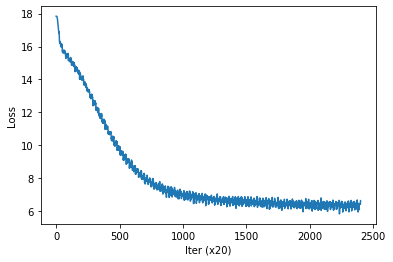

페이 [ 0.9996143  -0.06560486  0.7464112  -0.21237491 -0.13539684  0.14479905
  0.7879411   0.03691424  0.18148494  0.5461438   1.5557566   0.39808866
 -0.3213043  -0.4618349  -0.83480704  0.52893436 -1.1310635   0.58744484
  0.17363732 -0.34388953  0.9074078   0.97959656  1.0106658   1.6276199
 -0.45406893  1.309814    0.46638414 -1.1122997  -0.05667371  0.48650762
  0.9592055   0.90736026  0.07413334  1.4467032  -0.03584175  0.01670503
 -0.5138662   1.0417894   0.08271442  0.6429362  -0.4982295   0.49994034
  0.0415569  -0.06275459  1.1348615  -0.4338224   0.35297382 -0.8348518
 -0.17809959  0.70597017]
잘나온다고 [ 0.27904105  0.6486612  -0.514619   -0.5844021   0.7470114  -0.9782538
 -0.05262011  0.9507197   0.6433005   0.6581741  -0.47637454  0.6602039
  0.4391232   0.80087805  0.38005704  0.5279923  -0.0195728  -0.67237765
  0.00351455 -0.13207684  0.30682328  0.80539876  0.15557872 -0.6861418
  0.715819   -0.9235227  -0.23632635  0.6594376  -0.53450626  0.635473
  0.87897396 -0.4039273

하면서 [-0.00490373 -0.7231973   0.47897005 -0.68808633 -0.37410095 -1.5330737
 -0.90499467 -0.50934523 -0.68540007  0.6639892  -0.9155472   0.9648788
 -0.23006797 -0.3269622   0.6241331   0.43807924  1.3452709  -0.00863837
  0.1232061  -0.34800968  0.43970707  1.1821811  -0.3742986  -0.2672068
 -0.6620711  -0.39334923  1.1337367  -0.3237739   0.0158651  -0.7480436
 -0.4133059  -0.6159258  -0.16832532  0.49585828 -0.93375075  1.4788959
  0.7226694   0.4301284   0.06110535 -0.2659987  -0.27204537 -0.4113539
  1.1718696   0.13765436  0.4067807   0.6337929   0.6394413   1.2075913
 -1.8519734   0.00901756]
좋을 [ 1.9173489  -0.8473421  -0.3301828   0.58768594 -0.4484736  -0.55673707
  0.16908208 -0.43427607  1.0505439  -0.60627204  0.65408486 -0.6205378
 -0.9905169   0.93825024  0.80149287 -0.6173585   0.32060918  0.25081262
  0.7677841  -0.4037558  -1.1029557   0.5256688   0.25641355  0.11802112
  0.5209615   0.26219591  1.1827118   0.6344444  -1.406868    1.0276365
  0.17520803 -0.33883825 -0

  0.04298675 -1.271462  ]
하십니다 [-0.17456314 -0.970865    0.73712415  0.09636926  0.6949145  -0.06734657
  0.6957003  -0.7519683  -1.438542    0.84693974  0.93958867  0.84804726
 -0.39312235 -0.79501444 -0.7867472  -0.5207126  -0.42945734 -0.83823574
 -0.52856266  0.36275688 -0.89979786  0.93687254  0.24577239 -0.8141754
 -0.53035945  0.84760404  0.91953075 -0.25416973 -0.5415351   0.23851195
 -0.27363002  0.47121826 -0.12392776  0.3492277  -0.38302794  0.6751175
 -0.57666785 -0.52069074 -0.89172745  0.3386217   1.0015246  -0.8023896
  0.5217751  -0.815756    0.54400456 -0.20881248 -0.2694604  -0.20092538
 -0.8659213  -0.3133842 ]
9700 [ 1.0137638  -1.1794931   0.60887873  0.54178846  0.69148034 -0.95976007
 -0.29051366 -0.8082302  -1.0626284   0.38555965 -0.2698791   1.0431783
 -0.16673961 -0.55114365  0.13201435  0.00507387 -0.75359464 -0.47530904
 -0.21388304  0.00975085  0.350515   -0.16745915  0.81741995  0.05274264
  0.36627904 -0.40432745 -0.53378075 -1.2637718   0.2512983   0.22

로그인오류 [ 9.9034721e-01 -1.0402496e+00 -1.1869123e+00  8.1094337e-01
  9.2398524e-01 -1.5181729e+00  3.9880984e-02 -1.3942704e-01
  2.7989075e-01 -8.8352817e-01 -6.4284158e-01  5.0253913e-02
  1.1111075e+00 -2.4134932e-01 -9.8387325e-01  2.7218932e-01
 -1.7722604e-01  2.2325346e-01 -5.8597738e-01  2.4738967e-01
  2.5517275e-04 -2.0825505e-02  7.4768364e-01  2.3076716e-01
 -8.1839424e-01 -1.6025352e-01 -7.7385104e-01 -1.2848141e+00
 -8.6967367e-01 -1.6605680e+00  5.7930034e-01 -3.1528467e-01
  1.1069343e+00  1.0091881e+00  6.4096737e-01 -5.2530950e-01
 -6.8180728e-01  2.0204328e-02 -9.4614100e-01  1.8228028e-02
  8.1816238e-01  6.2552035e-01 -1.3990716e+00  1.2902734e-01
  1.5253571e-01 -4.7478032e-01  2.7861319e-02 -5.7696372e-01
 -1.0226372e+00  4.5759377e-01]
그게 [-0.97104114  0.03869741 -0.30710512  0.63540804 -0.4646978   0.32916996
  0.7237944   0.46525908  0.7268845  -0.09910508 -0.9061413  -0.10618743
  1.07366    -0.239811   -0.08111933  0.15355211 -0.59913886 -1.4553822
 -0.63964

  0.38618454 -0.2252767 ]
아니면 [ 0.8470589  -0.62266016 -0.69045144 -0.19863683 -1.0517863  -0.6819323
 -0.28428304 -0.619004   -2.0300114  -0.8543041  -0.7478693   0.7950746
  0.46335235  0.6447291  -0.37536365  1.1320857   0.25773722 -0.6712103
 -0.01853981 -0.364783   -0.5495747  -0.76555586  0.5645962   0.87930787
  0.49251354  0.18366344 -0.16887873  0.19832572  0.11754539  0.12886989
 -0.28158858  1.5222783   0.92099625  0.16942085 -0.21112694 -0.20040458
  0.52954876  1.0084679  -0.78684354  0.7388363   0.8732081  -0.3638062
  0.08367227 -0.4028484   0.5552076  -0.6813487  -1.1059177   0.03725387
 -1.2685046  -0.35680413]
찾거나 [-0.67703325  0.25364473 -0.5490371  -0.67462474  0.3869973  -0.17390189
  0.598706    0.7245332  -0.42291364  0.56507355 -0.3812475   0.1078041
  0.6956074   0.67214686  0.6038148   0.77390593 -0.76438266 -0.5644758
 -0.25925833 -0.07214851  0.304089   -0.22781926  0.5088343   0.47101155
  0.90792197 -0.18381257 -0.30636647 -0.54233164  0.71403724  0.116017

그리구 [-0.1880781  -0.0119708  -0.6291353  -0.22917537  1.2551835  -0.54493237
  0.12870637  0.22286056  0.09536488  0.5234169   0.91006655  1.1642817
 -0.2127024   0.6535006  -1.3352541   0.5941272  -0.07054276  0.6341697
 -0.27868912  0.56298035 -1.2258036   0.7244611  -0.20411623  0.9766784
 -0.21301825 -0.7411099   1.0000187   0.13141824  0.32936552  0.02632573
 -0.13732581  1.0908769  -0.42404613 -1.3716614   0.43257728  0.84273624
 -0.10916404  1.4179702  -0.05218373 -0.07632095 -0.59128886  0.79919934
 -0.47794074 -0.04001018 -0.8845228  -0.32306418  0.5470592   0.06001807
 -0.50558335  0.9179912 ]
무음 [ 0.5754214  -0.5121708  -1.0938208  -0.84368736  0.20768695  0.5798937
  0.15881121  0.9725499   0.42369705 -0.10207717 -0.26225123 -0.04764816
  0.04475076  0.33826938  0.40019074 -0.37110537  0.7349647  -0.3578397
 -0.41811693  0.63520217 -1.414652    0.8659475   1.3687627   0.81854504
  1.5096875  -0.30047154  0.1740957   0.26463348  0.26191705 -0.17571986
 -0.5174304   0.6802584

 -0.86995244  1.2888098 ]
부분 [-0.3688232   0.10642156 -0.9620811   0.4480564   0.12143307 -1.1656492
  0.03401118  1.3325452   0.18222132  1.2897916   0.2868485  -0.66405606
 -0.68948275 -0.15866749  0.7604065  -0.74495786 -1.209031    0.48972836
 -0.86509585 -0.751558   -0.5036192  -0.07690595 -0.6240961   1.6223799
 -0.6872275   0.16618462  0.15145256 -1.4155897  -0.6762666  -0.57330173
  0.2532574  -0.4577609  -0.33120006  0.7616862   0.4538197   1.3592511
 -0.03878698 -0.9650403   0.4439733   0.23197067  0.42181325  0.8897913
  0.37866262 -0.01943959  0.24859169  0.22341055 -0.7201888  -0.44059932
 -0.35222036  0.5210824 ]
상관 [-0.34136987  0.234288   -0.8033882   0.8476819   0.5966214   0.5930981
 -0.39285648  0.58495885  0.71927613 -0.40659848  0.6301431   0.07331049
 -0.6745366  -0.50061244  0.57665074  0.71843374 -0.761179    0.34618327
  0.79296434 -0.7609527   0.14426471 -0.58923405 -0.44267243  1.3795247
 -0.23130001  0.5719148   0.58785766 -0.26918793 -0.67489916  0.44912088

 -0.7399206  -0.4195225 ]
홍채 [-0.7516187  -0.5883553  -0.64515674  0.27221513  0.6521129   0.8718175
  0.6130239  -0.15156877  0.29950088  0.88158053 -1.1899633   0.8267428
  0.70462555  0.31132933 -0.8964423  -1.2450359  -0.4106426   0.32690257
  0.92819     0.7703973  -0.5593978  -0.41776952  0.8852593   0.7033154
  0.65549606  1.1079019   0.6601018   0.7243257   0.7626158  -0.89875376
 -0.67186517  0.6926609  -0.5793774   0.06881497 -0.6750392   0.4576364
 -0.6450497   0.19132441  0.9488237   0.32970715 -0.6588878  -0.3242253
  0.72424805  0.87546927 -0.6761809   0.516258    0.70942354 -0.43794596
 -0.7373677   0.87104964]
센서 [-0.18407543 -0.6724704   0.26675984  0.80009145  1.0397413   0.8161586
 -1.12312     0.19605446  0.00960443  1.0347387  -0.97919005  0.6338189
 -0.6777808   0.50383323 -0.20068721  0.688398   -0.4955552   0.43539286
  0.3298648   0.00486493 -0.59176093 -0.41312486 -0.32017663 -0.91601646
 -0.36143422 -0.57186013 -0.04049159 -0.7949445   0.21931525  0.24279623


죽는 [ 0.6372652  -0.5929213   0.616244   -0.23751606 -0.44343764 -0.3935739
  0.297263    0.29615125  0.83957165  0.7946897  -0.08216964 -0.25276166
  0.9870271  -0.47663942 -0.0972921   0.76661116 -1.544153   -0.89651036
  0.81286585  0.66357744 -0.67052895  0.40812522 -0.82679427 -0.5669682
 -0.6213786  -0.14333622  0.9488038   0.52424526  0.78501976 -1.2042919
 -0.705565   -0.85224605 -0.51131696  0.81522214  0.40130824  0.8305443
 -0.61622787  0.5517177   0.3640352  -1.0940738  -0.37199253  0.66764313
 -0.7259858   0.22697695 -0.8500786   0.50248677 -0.7567306  -0.56013167
  0.74897105 -0.47754845]
날짜 [-0.9016305  -0.6621669   0.57439923 -0.43811455 -0.19400062 -0.717747
 -0.20695858  0.4976064  -0.27756235  0.34605712  0.7734544  -1.5150807
 -0.6050714   0.22877713  1.379045    0.45868087 -0.04234137 -1.1154803
  0.40438756 -1.3631477  -0.43857765  1.0896854   0.10507075 -0.67890215
 -0.47008553 -1.0260129   0.8223208   0.28530946  2.04601    -0.0828622
 -0.44834208 -1.1123159   0.

 -1.3206983   0.33955914]
반납 [-0.34167486 -0.02583781  0.06677841 -0.00714839  0.97447985  0.21334527
 -0.14353438  0.91943073 -0.15238054  0.4172647  -0.76809055  1.0132856
 -0.31240207  1.3004501   0.68567485  0.71043634  0.8374005  -0.03245708
 -0.08074634  0.3833281   0.33047482  1.6541718   0.16222638 -0.10740105
  1.4901066  -0.01825585  0.37686032 -0.9236083   0.5376287  -1.4279552
  0.3334072  -1.0284946   1.1208878   1.5118951  -0.63207585 -0.08565471
  0.6900657   0.36835906 -0.63312984 -0.04197527  0.13508436 -1.4277704
 -0.6892426   0.8086834  -0.44976312 -0.5655059   0.5302292   0.586436
  1.0033356  -0.24654792]
바꿔 [ 1.20537138e+00 -9.29326415e-01  4.68747944e-01 -1.00050044e+00
  3.06738257e-01 -7.62246728e-01 -5.90038538e-01 -1.04524040e+00
 -3.72849964e-02  4.24961358e-01  9.75889936e-02  1.02175140e+00
 -7.96420515e-01  1.01285219e+00  3.63743305e-01 -1.21203452e-01
  3.26170206e-01  1.01345465e-01 -4.66558307e-01 -1.02902758e+00
 -4.51286107e-01 -1.22309542e+00  1.26

 -0.84460074  0.78214496]
바꿀 [-0.8636909   0.5810717  -0.06467962 -1.1726431  -0.35115927 -1.1346765
 -0.63676894 -0.2795615   0.2929592  -0.6324602   0.40268013  0.27567106
  0.15466478  0.74960643 -0.08346724  0.81225926 -0.6348751   0.14576046
  0.12043128 -0.04211416 -0.04067822  0.55160844 -0.39701796  0.70060366
 -0.11785889  1.7842847  -0.07113282  0.66668737  0.79185945 -1.2361919
 -0.20626734 -0.35987416  0.8604043   0.09457686 -1.0517644   0.1110782
  0.0936882  -0.93481845 -1.1472161  -0.24748278 -0.1085406  -0.3349173
  0.32031155 -0.60447115 -1.6768286   1.0177404   0.19014296 -0.20247543
  1.249877   -0.7458853 ]
유학 [ 0.67129874 -1.2157329  -0.9078718  -0.9754359   0.7377257  -0.7923573
  0.9476467   0.90203065  0.13674992 -0.85447335 -0.7567446  -0.15058528
  0.5873375  -0.17294097 -0.72942984 -0.8650294  -1.2591578  -0.45412633
 -0.5326276   0.5983101   0.44870207 -0.09102461  0.72372365  0.04084717
  0.874137   -0.33874846 -0.82368135  0.40177235 -0.16289695  0.0900260

  0.20028223  0.34288266]
챌 [-0.85201627 -0.65865475  0.63401717 -0.815353   -0.33795133 -0.5596506
  0.32038924 -0.89902824  0.7087958   0.615623    0.36655167  0.97768956
 -1.2148784  -0.8935904  -0.4910966  -0.6902993   0.10669971 -0.31909645
 -1.0398687   0.6213102  -0.60586375 -0.56122595 -0.30365857 -0.50055593
 -0.6476761   0.17163645 -0.6390769  -0.82796067 -0.66602254  0.99480623
  1.0382488  -0.6308052  -0.6869048  -0.49285355 -0.6514492  -0.7760706
 -0.7140854  -0.2971299   0.588394    0.86175704 -0.52026176 -0.3175869
  0.57447296  0.42488113 -0.2195935   0.714644   -0.9075071   0.7945423
  0.3659508   0.49982587]
린지 [-0.5758508  -0.46579334  0.92981106 -0.69288963 -0.3468477  -0.71233386
  0.19823797  0.7903738   0.73653924  0.7250075  -0.2686203   0.06010671
 -0.9465886  -0.61692095 -0.6101835   1.0197662   1.1131431  -0.65981203
 -0.16289255 -0.77839726 -0.7562505  -0.50321364 -0.99627286 -0.6162599
 -0.74161613  0.36867788 -0.8887435  -0.29768053  0.81880796  0.24942036

뜨는 [ 0.58431953 -0.34875342 -1.1504018   0.4784718   0.22500134 -0.3466589
 -0.26915526  0.40192217  1.1463473  -0.99071217 -1.0594788   0.16112466
  0.80983806  1.0197852   1.232356   -0.11560035  0.24150059 -0.42495438
  1.0774932  -0.10003294 -0.01176921  0.14953862  0.46254104 -0.69472337
 -0.6897685   0.11857611  1.0352534   0.01536175  0.35964277  0.08364778
 -0.4201241  -0.9457789   0.13960055  1.5115983   0.6235302   0.31856865
  0.07737801 -0.8053236  -0.802212   -0.2598599  -0.811699    0.12894969
 -0.01031997 -0.32990313 -0.3803024  -0.47587335 -0.91316026  0.84877783
  0.02200674  1.0752008 ]
킬때* [ 1.3191661e+00 -6.5992230e-01 -1.3200948e+00  5.6950772e-01
  3.4179035e-01  2.8257170e-01  3.8732463e-01 -5.0445795e-01
 -9.7087044e-01  3.2520121e-01  9.0293664e-01 -1.2043869e+00
 -4.4854715e-01 -2.6557979e-01 -1.2349615e-01 -3.7314359e-02
  9.6589708e-01 -3.9620763e-01 -6.2683326e-01  2.5094590e-01
 -5.9217447e-01  1.6621603e-01  7.8160655e-01 -9.1533791e-03
 -2.0397618e-01  3

 -0.8971579  -0.45783612]
미스터 [-3.7529618e-01  4.0346691e-01 -9.1124314e-01 -7.7963358e-01
 -6.1913550e-01 -6.3503397e-01  7.1362346e-01  2.8598180e-01
 -5.9803724e-01  7.2926241e-01  7.7522886e-01  6.1588794e-01
  9.2640746e-01  1.9643934e-01  1.4047726e+00 -4.4674617e-01
  5.5163771e-01  6.1124610e-04  5.9820437e-01  5.9449244e-01
 -6.2511772e-01  6.4070660e-01 -1.1361838e-01 -8.3032948e-01
  7.8046852e-01 -5.0507051e-01  2.1577916e-01 -2.9987535e-01
 -4.5452842e-01 -2.7759179e-01 -5.5478227e-01  3.6860928e-01
  8.1825322e-01  7.0825666e-01  3.9228991e-01  2.0590454e-01
  8.2905090e-01  7.3787796e-01  6.3830113e-01  6.1810052e-01
 -4.6869570e-01  6.1100036e-01 -7.4071920e-01 -7.6095194e-01
  4.1288859e-01 -8.5744500e-01 -6.5487963e-01  1.7861824e-01
 -1.3714720e-01 -9.3003380e-01]
블루 [ 0.6827206  -0.71491313 -0.11378485 -0.68323255 -0.17714353 -0.2832811
 -0.27483273 -0.6753886   0.3053413   0.09499124  0.30562508  1.1433933
  0.02231333 -0.30179167 -0.32278702  0.28317258 -1.0628768

  0.2641243   1.3659091 ]
울리면 [-1.1403941   0.6149536  -0.7484795  -0.7802995   0.8147015   0.17804787
  1.4951354   0.92738795 -0.07246029 -0.2284942  -0.8465358  -0.7442059
 -0.41689494  0.01218538  0.84810835  0.77503353  0.32878703  0.70553327
 -0.59952104  0.09071601  0.6772808  -0.39878535  0.4934208  -0.5201974
 -0.50484765 -0.3643961   0.7962837   0.6660622   0.82510173 -0.48375624
 -0.15757017 -0.42277887  0.04700256  0.38998374  0.6450602   0.7585237
 -0.58089375 -0.47022644 -0.9555861  -0.8085611   0.9247293   0.64929926
  1.0465497  -0.28500423  0.3817483   0.5356652  -0.5571065  -0.7953543
 -0.9083528   0.7874741 ]
손 [ 0.41716683 -0.02892029  0.21489123 -0.2952113   0.5928164  -0.7429677
  1.2514341   0.7134624   0.82717365 -0.28057176 -1.0875133  -0.9968585
 -0.55411077 -0.75028366  0.03538713  0.76601046  0.4591322   0.03306014
  0.5215445  -1.0672231  -1.1286412  -0.77931696  0.8013862  -0.426472
 -0.31818214 -0.31494024  1.4488126   0.8516886   0.91247654  0.01194097
 

  0.7144592  -0.3365007 ]
dir [ 0.6392519   0.6453731   0.6668447  -0.77939624 -0.74403495  0.6945183
 -0.7466702  -0.7005276   0.92630213  0.74121064 -0.32380962 -0.7172824
 -0.7094552  -0.5245964   0.67128295  0.8117385   0.5307356  -1.1167742
  0.65661544  0.7678483  -0.87523925 -0.4563756   0.79337525 -0.47798732
 -0.7042314  -0.53095603  1.1645715   0.9298134   0.717314    1.0838703
 -1.0116494   0.64953184 -0.6957589  -0.958238   -0.01506211  0.76907456
 -0.5946002   0.77972865 -0.8705703  -0.45370942  0.7366733  -0.62069327
  0.79626983 -0.5606607  -0.7764965  -0.45788994 -0.6516968  -0.63343185
  0.6753034   0.5826974 ]
828 [ 0.75901085  0.148218    0.48192587 -0.56057274  0.36757314 -0.30246803
  0.7799092  -0.85930735 -0.7171984   0.26194984 -0.5827773   0.31269047
 -0.3950259  -0.6881759   0.75864935 -0.42896438 -0.5352936   0.72517365
  0.2522086  -0.78620154  0.86459166 -0.58681035 -0.9449969   0.75873506
  0.82656777 -0.29893366 -0.36113995 -0.7640638  -0.6147157  -0.9061

  0.09371828 -0.3919078 ]
시장 [ 0.68821913 -0.3087209  -0.2575893   0.7688214   0.7110838  -0.7356048
 -0.83710426 -0.6460667  -1.0861247  -0.4033762  -0.93901134 -0.7918862
 -0.68052447 -0.5230272   0.92955816 -0.7008239   0.6029542   0.52360624
 -0.4872372   0.60525995 -0.6760616   0.15800802 -0.69224113  0.81769556
 -0.38953602 -0.69931686  0.54010594 -0.8015546  -0.46510085  0.6547177
 -0.51243055  1.7073658   0.9938513  -1.0205582   0.58963406  0.6217846
  0.5926109  -0.5889552  -0.6800958   0.68485934 -0.6544347   0.6479325
 -0.9962027   0.60025585  0.88835245 -0.3768471  -0.5979264  -0.8280414
  0.6192813   0.86421716]
할려 [-0.8519982   0.092113    0.05182962  1.037442   -0.64895135 -0.06594339
  0.45475757 -0.39065966  0.5782075   0.7188216  -0.80319315 -0.6777403
 -0.296322    1.032799   -0.8078338  -0.7104768  -0.72363406  0.650963
  0.5754941  -0.720279    0.23182939 -0.08658735 -0.4456763  -0.05913737
 -0.82500523 -0.15393841  0.5379658  -0.7412921   0.03445652  0.7791193
  0

 -0.56101304 -0.01794753]
하셨던것으로 [ 0.6693636   0.39429858  0.38354924  0.7001006   0.8066821   0.06278296
 -0.09947302 -0.7892038  -0.517185    0.71529615 -0.5546309   0.634814
 -0.40401828 -0.73240685 -0.72961724 -0.422746   -1.0384499   0.51440066
  0.62783074  0.34465796 -0.91786885  0.33143377 -0.6655518   0.83813006
  0.56479937 -0.32400376  0.70728695  0.6217894   0.51390964 -1.0496817
  0.5332848   0.10020231  1.2022121   1.1868442   0.77829486 -0.58328617
 -0.62743765  0.19536018  0.22045627 -0.68334395 -0.70486104  0.38388312
 -0.74391377  0.38018835  0.67637724  0.8274141   0.9128687   0.7689632
 -0.9446144  -0.65913147]
미성년 [-0.5641071   0.41121018 -0.19937618 -0.05305781  0.56959754  0.35948434
 -0.11078607  0.42269543  2.1936576  -0.21712902 -1.2130151  -0.29614663
  0.5266327  -0.30339313  1.4780167  -0.19629759 -0.23294947 -0.99464035
  1.0030046   0.5953394  -0.21963096 -1.6513925  -0.59466827  0.13873285
  0.81106323  0.5890086   1.0049635  -0.6904131  -0.08416428 -0.4

  0.9322449   0.67430985]
정확도 [-0.77382797 -0.7174086   0.6837271  -1.2720523   0.67319024 -0.8547253
  0.6859906   0.7073879  -0.43569744 -1.1273677   0.6516796  -0.75627923
 -0.85781544  0.42152274  0.42804965 -0.7250421  -0.8404403   1.1245872
 -0.49956736 -1.1173948   1.0315498  -0.5577251  -0.6191904  -1.139111
 -0.8447871  -0.7389346  -0.562631    0.7279469  -0.6693063   0.5117238
 -0.70011765 -0.79274833 -0.6403328   0.42133757  0.51924616 -0.73064005
 -0.655287    0.63078177  0.70343554  1.0406618  -0.42668012  0.7173672
 -0.61340094  0.84757876  0.6593171   1.1187615  -0.84806865 -0.7819542
 -0.7028966   0.4985487 ]
향상 [-0.5857892   0.19826524  0.9226078  -0.8813858   0.7753033  -0.799096
 -0.36727956  0.7879756   0.2974116  -0.6414875  -0.35191855 -0.73909307
 -1.2348131   0.99034786 -1.128983    0.3552795   0.6120909   0.8326699
  0.23181939 -0.47067112 -0.45635247 -0.9439484   0.70637304  0.6970286
 -0.10663393  0.7042395   0.80172235 -0.43848553 -0.36370352 -0.85542226
  0

 -1.0444024  -0.56300193]
트수* [-0.3749855  -0.46472856  0.59467214 -0.518279    0.32726434 -0.68186116
  0.6538775  -0.81202185  0.7071652   0.4300631  -0.50140166  0.38561326
  0.19787674  0.8768344  -0.87583774 -0.837004   -1.0326024  -0.7466574
  0.1224713   0.06757857 -0.48546636  1.5146911   0.61971647  0.638634
  0.82759273  0.6273855   0.3655539  -0.42855883 -0.30319017  0.81117636
 -0.9219236   0.12742683  0.8752454   0.8171347  -0.9537712  -0.69906366
 -0.95251465  0.64564633 -0.18885131 -0.6073169  -0.40965307  0.5163775
  0.29248554 -0.83991325  0.7745735   0.05970967  0.6397522  -0.88508016
  0.61391515 -0.6054328 ]
끼리 [-0.2329002  -0.9485269   0.3151362  -0.7485797   0.64591473 -0.6489213
  0.2241435  -0.3829958  -1.0506238   1.1186184  -0.22035499 -0.51079327
  0.4636686  -1.1140001  -0.8939031  -0.04469428 -0.6848076  -0.60963
 -0.32496664 -0.601505    1.7880825   0.74835336  0.52576125  0.24772885
  0.8065914  -0.48675275  0.3587112   0.14933679 -0.6205862   1.0492021
 

  0.24023683 -0.69389534]
계시나요 [-0.40054622 -0.25403297  0.00401664  0.09385934  0.59433305 -0.65733993
 -0.40513963 -0.17559281  0.64343405 -0.7889812   0.679797    1.00107
 -0.64993525 -0.8336193   0.16661057  1.363872   -0.72676957 -0.07344392
  0.7437032   1.1865094  -2.1740859   1.0001739   0.9523962  -0.47026458
 -0.44342718 -0.24110577 -0.7696698  -0.25331044  0.371255    0.24349834
 -0.65745014 -0.66036344  0.4082947   0.7643443  -1.4767293   1.3115783
 -0.6078137   0.4911013  -0.15229583 -0.37286037 -0.88757396  0.7850675
 -0.09655978 -0.65324163 -0.9556497  -0.18488722 -0.21901362 -0.3364965
 -0.9709207   0.26645288]
ls [ 0.73182064  0.88866705 -0.93856126  1.2328944   0.610171    0.683144
  0.39582852 -0.8413371  -0.6685036   0.24254175 -1.2435007   0.11098886
 -0.8187624  -0.21783741 -0.10764375 -1.1865418  -0.8512771   1.6965321
  0.6783999  -0.0351139  -0.61131835 -0.22053051  0.6684973   0.5037733
 -0.8398057   0.87811416 -0.7709151  -0.7825243   0.7049228   1.0774947
  

  0.87261176 -0.6712473 ]
출이 [-0.66087914  0.71755815 -1.3451005  -0.7646755  -0.30223435  0.06066848
 -0.7078361   0.9129566   0.81916124  0.3936826  -1.0328213   1.542055
  0.26792765  1.360538   -0.81140196 -0.7078465   0.16443056 -0.09147988
 -0.59852844 -0.65986204 -0.8697797  -0.10869057 -0.6293499   0.56272954
  0.9200315   1.0109816  -0.8060661   0.8519557   1.1198914   1.3113134
  1.1199417  -0.54546195  1.0028181  -0.9184156   0.6488347  -0.2796053
 -1.4943575  -0.728382   -0.2152084  -0.4922115   1.1940026  -0.7731253
  0.49482515  0.15319489 -0.92413     0.09936778 -0.46595967 -0.16500334
  1.3697016  -0.8161358 ]
split [ 1.186359    0.5530803   0.20665544 -0.4434505  -0.03013432 -0.7917706
  0.6716359  -0.13841935 -0.7456228   0.65042895 -0.99255484 -0.72725725
 -0.6152163   1.3947856   0.67570496  1.5065768  -0.06609996 -0.42921624
  0.5060227  -0.89926124 -1.2470517  -0.4298535  -0.52659625  0.6106627
  0.49623787 -0.47998112 -0.6613457  -0.7531212   0.6863979   0.307591

시즌 [ 0.7154421  -0.74237514  0.21857814  0.17903347  0.0267545  -0.526918
 -0.30443487 -0.5988553   1.0603331  -1.1925707   0.7850442  -0.75905627
  0.71691865  0.15381588  0.27816167 -0.66052616  0.47522676 -1.9738507
  0.5911998  -1.5577381  -0.76125795  0.8205807  -0.20629448  0.56114995
  0.82467926 -0.24705991 -0.99316573 -0.646539    1.2621183  -1.0007463
  0.7398798  -0.5698429  -0.81588745 -0.9041353  -1.109359   -0.3012219
 -0.7242031  -0.05100675 -0.8136505  -0.6580347   0.39760363 -0.55068994
  0.7918641  -0.25313044 -0.0747958  -0.37127075 -0.40191746  0.41938928
  0.37165433 -1.3139198 ]
1~4 [-0.10795535  0.8219927   0.12292068 -0.08344334  0.7436961  -0.8363029
  0.761314   -0.5865029  -0.55892265  0.5839575   0.2929142  -0.87141854
  0.8054227   0.10674196  0.42210424  0.08456562  1.0494033  -0.09075041
 -0.6534717  -0.8150816  -0.23028806 -0.12020301  0.20345761 -0.5571152
  1.0316931   0.9173693   0.7884642  -0.8019033  -0.09929866  0.7475184
 -0.34965917 -0.03555782 -

스케 [ 0.7301672  -0.974796    0.7458307   0.5422301   0.12358172  1.0214937
 -0.70295554  1.125664    0.6335334  -0.49411958 -0.5068088  -0.8446168
  0.9567297   0.5328592  -0.811297   -0.34459662  0.02731023 -0.9108064
 -0.5672506   0.5575833   0.7145872  -0.9979893   0.6484235   0.54416054
 -0.40063038  0.61085576  0.60019547 -0.6994092   0.44286555 -0.879355
  0.75456864  0.4236637   0.5796158   0.5399403  -0.728403   -1.1719204
 -0.74176055  0.74371636 -0.2591214  -0.753107    0.6813686   0.6197064
  0.8726473  -0.7678235  -0.3503357  -0.9265641  -0.60900843 -0.687733
  0.4550212   0.7267538 ]
알씨 [ 0.7361415  -0.72133225  0.909858    0.44685107 -0.9697898   1.2183169
 -0.4745811   0.5345866  -0.5008401  -0.51788896 -0.6039544  -0.77948934
  0.7442486   0.12407053 -1.3450295  -0.19625297 -0.5975763  -0.83666956
  0.56221634  0.93666387  0.737611   -0.12374659  0.67640454  0.31851038
  0.6953411   0.31166652  0.6578733  -0.8470968   0.6576336  -0.9918625
  1.2273028   1.0040699   0.62

씩 [-0.6127265   0.6188347  -0.67341894  0.19046488  1.2199023   1.2200576
 -0.64784837 -0.2102225  -0.58958757 -1.3102858   0.7233902   0.33751276
 -0.6432909   1.2968053   0.25774375 -0.34638265  0.02257658  1.2211092
 -0.12381512 -0.6155163   0.03074983  0.773888    0.15591426  0.77618384
  0.29071322  1.1915886   0.045076    0.07326762  0.67265624  0.02030023
  1.5591723  -0.37725297 -1.03835    -0.40649983 -0.9702433   0.11353804
 -0.71578133  0.69524944  1.0099443  -0.84810287 -1.1504996  -0.903665
  0.07985067 -0.6656888   0.11136156  0.5399569   1.1127329   0.18135105
  0.2845862  -0.39202312]
해가며 [-0.38874793 -0.67886966 -1.0342023  -1.0273077   0.8286116   0.53943396
  0.8875148  -0.23684676 -0.22548017 -0.5259504   0.8112569  -0.00852042
 -0.75283957  0.2307696  -0.4984083   0.51058465 -0.61361575 -0.13139667
 -0.6528256  -0.6009509   0.3440505   0.84566796 -0.4962074   0.4978301
  0.4874153  -0.5289098   1.3132689   0.26789004  1.0561762  -0.92982036
  0.2807833  -0.61574405

껴져서 [-0.6583834  -1.0940477  -0.9882999  -1.6205416   0.7373114   0.7104764
 -0.2866224   0.73640084 -0.774861   -0.30595154  0.71883714  0.24659033
  0.7269773  -0.7299271   0.6552787  -0.6115067   0.50175846 -0.7754166
  1.1784036  -0.9000274  -0.23137231 -0.03506842  0.03694497 -0.03353023
 -0.3994901   0.3155494  -0.55199647 -0.8219339   0.4237635  -0.39010912
  0.48342994 -1.5823308  -0.00653832  0.3837134  -0.66500634  0.06118108
 -0.76915264 -0.8458398   0.00309615 -0.04271631 -0.06866148  0.4902397
  0.7155296  -0.70552844  0.6879861   0.6290988  -0.29414833 -0.6415413
 -0.9021579   0.5772288 ]
더리 [ 1.068915    0.78746784 -0.85155493  0.8322371  -0.24457988 -0.5763867
 -0.37491915 -0.5872016   0.56165165 -0.91871464  1.2632444  -0.04749374
 -0.43625402  1.1641003  -0.7764699  -0.43451548 -0.47603667 -1.1262505
 -0.6123081  -1.0121396   0.82304406 -0.69981354  0.15472509  0.18324989
  1.1726029   0.73402697  0.07516991 -0.7404481  -0.44495177 -1.088569
  1.1427654   0.6215409  -

당한건 [ 0.86663663 -0.723226   -0.7347971  -0.43628478 -0.44999856 -0.34997132
  0.3907741   1.1197582  -0.9266092  -0.7562913   0.26438335  0.8734489
 -0.3981134  -0.45375258 -0.3191774   1.0295712  -0.8721178  -0.36540666
 -0.5778083  -0.03690201 -0.6085416  -0.26019698 -0.816889   -0.8981612
  0.37047085 -0.47171184  0.05697661 -0.7616433  -0.26116654  0.53160316
  0.68054414 -0.16182321 -0.2797402   0.83136517  0.602776    0.6648228
  0.80470085 -0.34929165 -1.0777693   0.8959495  -0.02388614 -0.01438575
  0.34855708  0.25386992 -0.03191261 -0.13386473 -0.7047488  -0.27871358
  0.23536505  0.8400595 ]
빡친다 [ 0.62225574 -0.8504317   0.7223463  -0.5493178   0.08741356  0.8550654
 -0.5142834   0.44978297  0.907022   -0.84166646 -0.72059655 -0.6793796
  0.84059036  0.14936092 -0.45351    -1.2331432   0.42370808 -0.35480797
 -0.8288113  -0.85005254 -0.6284619   0.71903026 -0.36339787  0.81845397
  0.80749387  0.8676856  -0.6225515  -0.79971546  0.50908846 -0.78531337
 -1.204427   -0.708561

  1.6215789   0.23890711]
하루 [-1.7744813   0.47317973 -1.3764971   0.6956001   0.31243476  1.7239453
 -0.3426888  -0.47162572  0.22815381 -0.10479561  0.150575    0.19208802
 -0.03092556 -0.22997247  0.2493615   0.08793072  0.58720696 -0.31635693
 -0.02023491 -0.21009384 -0.79242307  0.99680877 -1.1064584   0.12369444
  1.0673066  -0.3198576  -1.4568592   1.2362411   1.1349744   0.21504688
 -0.38410336 -0.08201768 -0.59463704  0.42596263 -0.6307243  -0.59426874
 -0.15400212  1.3815     -0.27345663  0.23023845  0.94484437  0.18817137
  0.1065665   0.946389   -0.09560559  0.1347516   0.28267634  1.5158097
  0.19008224 -0.36462605]
지난 [ 4.0700245e-01  4.1496563e-01  9.0891100e-02  7.6005721e-01
 -5.0915653e-01 -1.0357625e+00  7.3358601e-01  1.1749232e+00
 -1.0519729e+00  7.3245227e-01 -8.2934451e-01 -5.2603662e-01
  7.7301008e-01  1.5923084e+00 -6.2543172e-01 -1.6918957e-01
 -2.9844451e-01  9.4296908e-01  2.5427777e-02 -6.4502215e-01
 -4.4309181e-01 -4.0678063e-01  1.4543914e+00 -1.896312

  0.8777004   0.8244616 ]
적도 [-0.96528596 -0.54614496  0.3374547   0.25810283  0.06484702  1.4372905
 -0.79792666  1.1845119   0.05100868  0.48660594  1.4171193  -0.31884214
  0.19906434 -0.91576     0.21540958  0.5656003  -1.0457522   0.30742204
 -0.7269209  -0.787882    0.5859905  -0.76606125 -0.7882025   1.0652791
  0.9757851   1.0968752   0.71642107 -0.64372265 -0.20356125  0.10652445
 -0.70835733  0.84967756  0.9322081   1.4958551   0.20744249 -1.0937409
  0.18914254 -0.22608468  0.5678402  -0.07555511  1.1043781  -0.62850296
  0.42155045  0.47067365  0.7945733  -0.9283139  -0.17960988  0.5673931
 -1.0533332  -0.57220525]
사라져있네요 [ 0.32359704 -0.12182675 -0.9724334   0.9388712  -0.6522584   1.2348679
  0.8974804  -0.6523347   0.6322607  -1.0118318   0.6715433  -0.71278566
 -0.59772223 -0.5272855   0.7888505  -0.6190906  -1.2725081   0.25549665
  0.4550947  -0.5083575   0.20862913 -0.8483038   1.0134608   0.6552934
  0.62590003  1.070166   -0.72448826  0.24518384 -1.2941903  -1.0722

  0.62380713 -0.6284282 ]
거려* [ 0.74860686 -0.83946586 -0.8252024  -0.78854626  0.90451634 -0.81082046
 -0.6854516   0.88569915 -0.84751076 -0.6663388  -0.02842506  0.7248153
 -1.0123346  -0.9538155   0.85129976 -0.13028444  1.0763584  -0.6269095
 -0.7592526   0.51343566 -1.3154391   0.58379555 -1.0492346  -0.9532106
 -1.0397975   0.09516345 -0.69780886  0.835812   -1.0124444   0.04701168
  0.8998353  -0.6805795   0.7012802   0.910903   -0.01934562  1.0111803
 -0.8075719  -0.68092597  0.689278   -0.68368644 -0.48772126  0.70038956
 -0.8782591   0.7827846  -0.76489186 -1.4704562   0.75957704  1.0034614
  0.93586683 -0.20212094]
빔 [ 0.9509035  -0.33058375 -0.7416148   0.84471005  0.9664734  -0.03044089
  0.01147377 -0.15359604  0.78755355 -0.34777066  0.7193538   0.5778113
  0.2626665  -1.7762957  -0.20790836 -0.19377282  0.2276431   0.26860967
 -1.634919   -0.9210122   0.45986515  0.747143    0.23596351 -0.76184523
 -0.27180922  0.5800779   0.7286503  -0.6719812  -0.12036377 -0.02142405

  0.4608496  -0.5978257 ]
우측 [ 0.44261175  1.2074634   0.39230934 -0.87238395 -0.7087787  -1.1749161
 -0.6673168   0.80466366  0.96996635  0.14449726 -0.7261384  -0.27248332
 -0.18435484 -1.4901693  -0.40299633  0.92316496 -0.407068    0.96116126
  0.9516389   0.6411564   0.2834048  -0.22514166  1.2017989   1.0937741
 -0.68999755  0.9022827   1.513163   -0.30572906 -0.8320928  -1.094578
  0.04238256 -1.2063402  -0.02225805  0.07192689  0.06280415 -0.6447504
  0.8150864   0.21002074 -0.9262748   0.94183564  0.97517306 -1.0542603
 -0.51185364 -0.9463435   0.46348128  0.8643425  -0.90971035 -0.38312504
 -0.91093254 -0.26034695]
불빛 [-0.18824358  0.02419135  0.0253654   0.50156856  0.605046   -0.6894918
 -0.05654397  0.7565483  -0.2276431   1.0354035  -0.6098049   0.73272926
 -0.49334878  0.5828043   1.025647   -0.50782907 -0.6954291   0.2968868
 -0.6540977   0.6702667   0.5432429  -0.30445692 -0.40136454  0.62202775
 -0.52188194 -0.7753526  -0.29543388  0.54049265 -0.48057196 -0.881985
 -0

  0.8732088   0.3145159 ]
찾아봐서 [-0.71253663 -0.7923337   0.42114925 -0.85568684  0.55645055 -0.7190115
 -0.15654753  0.9277385   0.36168838 -0.12738593 -0.26204553  0.8708768
 -0.5665321  -0.88385105  0.49261248 -0.6210615   0.82185405  0.6004938
 -0.650596   -0.8310763  -1.1991825  -0.519996   -0.49053016  0.5440111
  0.22544047 -0.23359233  0.80952394 -0.7353643   0.48312378 -0.19583769
 -0.80864537  0.757667    0.6127538   0.3051932  -0.6750386   0.8513851
 -0.58641374 -0.23732722 -0.8170071  -0.6935258   0.7394358   0.10401677
 -0.71002233 -1.0269701  -0.6971699  -0.28589898 -0.5536912   0.4560343
 -0.24896856  0.8146716 ]
쓴지 [ 0.56639105  0.3613827  -0.71309274  0.03812959  0.75940216 -0.00397177
  0.8256332   0.25585195 -1.2921433   0.63138837  0.6217046  -0.28087243
  0.04807189  0.49049994 -0.38443047 -0.24107355 -0.76307034 -0.52861667
 -0.29722574  0.20908521 -0.5755045   0.75242543 -0.3797459   0.5321668
  0.2547649  -0.5369412   0.6466674   0.31296676  0.6151918  -0.9475120

  9.4556785e-01  5.7412520e-02]
아키텍처 [-0.5867571  -0.8681562   0.69329286 -0.78417283  0.7199001  -0.27614924
 -0.45185086  1.4749324   0.11823686 -0.47722042 -0.6201732   0.4087056
 -0.92589617  0.9718594   0.9898817   0.5935878  -0.6955393  -0.6400609
  0.8023595  -0.831293    0.60972476  0.68606836 -0.57290924 -0.26657203
  0.2564142   0.57388496 -0.03120905  0.22055596 -0.41848934 -0.9174673
  0.91492474  0.70567155 -0.41561124  0.92969406 -1.0349604   1.0053232
  0.01286    -0.04676459 -0.79311365 -0.22836685  0.9715115   0.839031
  0.19918615 -0.6708837   0.4719722   0.56756514  0.72196156  0.82456344
  0.35798225 -0.5325908 ]
바꿔야 [-0.6280014  -0.3143879  -0.12817238  0.93467975  0.16029505  0.6480954
  1.0739204  -0.7694102   0.546585   -1.1562271   0.33728942  1.7404513
  0.16071579  0.7781714   1.0126059  -0.15357585 -1.2875875  -0.7858944
  1.2365563  -0.36259067 -0.5466141  -0.0144102  -0.52264583 -0.43615493
 -0.37149194  0.15039523  1.5415881   0.14542858 -1.4430555   0.43

  0.13545823  0.3483045 ]
심하기 [-0.36101303 -0.35976717  0.57296187 -0.6760124  -0.48946413 -0.6083329
 -0.59836656 -0.89110446  0.21292138 -0.62581474  1.0334563  -0.22363715
  0.82028556  0.69444054  0.62212473  0.95188224 -0.05546255  0.7089028
  0.27878356  0.5983884   0.83506995 -0.34120035 -0.9445249   0.1548891
  0.21062917  0.9290397   0.8868424  -0.66726685 -0.20267306  0.43292686
  0.681577   -1.0614238  -0.80455893  0.8729385  -0.6496658   1.2071453
 -0.7841601   0.5713581  -1.0499532  -0.20638569  0.8342649   0.5571171
 -0.38875425 -0.43789026  0.65313226  0.77453446  0.68554956  0.5454271
  0.03552509 -0.54550475]
않았어요 [ 0.6984856  -1.0363154   0.42071062  0.83202946 -0.6490086   0.03204424
  0.28047577 -0.38853636 -0.11715729 -0.28542703  0.36305177 -0.6114577
  1.2138239  -0.4019097   0.75248235 -0.3230928  -0.1722737  -0.837867
 -0.5982245   0.80058634  0.23554708  0.81142694 -1.264858   -0.59481335
 -0.736577   -0.47096398 -0.12000236 -0.39430723  1.1630858   0.46064
  

  0.5926146  -0.46299076]
되거나 [-0.12945983 -0.28345898 -0.8385763   0.39416268  0.86641514 -0.05887031
  0.68939906 -0.552385    0.29555437 -0.3595569   1.6078606  -0.49447688
  0.8370135  -0.433706    0.7734935  -1.0545644   0.23125547 -0.2010194
  0.62399906 -0.368278    0.32163695  0.19851847 -0.12821439  1.043116
 -0.3348415   0.6655343  -1.3917435   0.6215907  -0.10429404  0.5917505
 -0.6960289  -1.0903131   0.05113903  1.3419915   0.14806436  1.1483345
 -0.6912355  -0.70628715  0.97185683  0.63086087 -0.44700015  0.66479945
 -1.5127087  -1.9512252  -0.20352712  0.55549914 -2.017043   -0.793405
 -0.62187654 -0.28468573]
셋톱박스 [ 0.68371594 -0.5441445   0.9545709   0.7047602  -0.95717025 -1.0596347
 -0.5377217  -0.54821557  0.9845203  -0.7181104  -0.22101478 -0.6440057
  1.3356228   0.41949347  1.4388059  -0.94865453  0.8203594  -1.1946948
  1.1822553  -1.0380404   1.1306183   0.8575075   0.9293361  -1.1696336
  0.6628671  -0.3397337  -0.75804585 -0.84686536  1.1157454   0.9177232
  

 -1.6330652   1.2076211 ]
올수 [-0.6504122   0.2793866  -0.43866593 -0.7792583   0.48586616 -0.54982334
 -0.71338797  0.5699081  -0.7212031   0.3359033  -0.8989738   0.41479406
 -0.57460886  0.27495924 -0.71556216 -0.7185778   0.59514064 -0.244297
 -0.6431827   0.8422662   0.6900017  -0.5401465  -1.0354862   0.7696464
 -0.7101184   0.37514332 -0.5477686  -0.17858347 -0.83885545  0.7902708
 -0.65575504  0.3710797  -1.072316    0.41482794  0.68692535 -0.75935215
 -0.6901061   0.20061375  0.8500008   0.7433414  -1.157123    1.2872322
 -0.2808138   0.6366835  -1.1561534  -0.5787463  -0.6027107  -0.4956761
 -0.44836846 -0.7726544 ]
잇죠 [-0.5155428   1.2182394   0.41489726  0.34745407 -1.0145202  -0.4473092
  0.90676314 -0.51534396 -0.44454136 -0.5758638   0.6178438   0.16905127
 -0.5063503  -0.19475493 -0.62746197 -0.7655554  -0.33695614  0.21798556
  0.36438105  0.68614507 -0.6826519   0.45224714 -0.9760737  -0.6795504
 -0.41235244 -0.6575978   0.543966   -1.0462412  -0.5240526  -0.7462763
 -

헸* [ 0.53427124  0.18910626 -0.5339789   1.3898467  -0.8755591  -0.812246
  0.6596147  -0.15175158 -0.55032617 -0.67582303  0.06907753 -0.61201763
 -0.8523651  -0.64278424  0.655323   -0.78396523  0.21776234  0.43319964
 -0.7076548   0.38385212  0.734287    0.6859333   0.8855209   0.57844514
  0.7213106   0.46388653  0.69689214  0.5605562  -0.5699539  -0.67685163
  0.7154551  -0.2837052   0.12915763  0.46428052  0.17199977 -0.11176165
 -0.6502799   0.63269794 -0.6546009   1.0660822   0.8864958  -0.49805564
 -0.66410273 -0.136662   -1.0441165  -0.54978216  0.4797075  -0.90117466
  0.2649276   0.72510666]
는데요 [-0.8708851   0.6732158  -0.708993    1.1364124  -0.6528959  -0.72323257
  0.5988927  -0.780361   -0.5371446   0.6059742   1.2670082  -0.6596374
 -0.7147581  -0.2312212   0.11546239 -0.06380922 -0.7137457  -0.58196104
  1.0318458  -0.53115517  0.6787137  -0.38761932  0.75860614 -0.33067802
 -0.5471187  -0.04628416 -0.910163    0.8152357  -0.6708562   0.7554656
 -0.8575341   0.673512

않은데 [-0.6565819   0.8418716   0.74860674 -0.68511486  0.7266446  -1.0373172
 -0.8774756  -0.7625337   0.8137953  -0.63013685 -0.8305549   0.61014086
  0.51159596  0.7764589  -0.668055    0.8625527   1.018267    0.7329324
 -1.0467545  -0.88180417 -0.74596834  0.6292246  -1.5699539  -0.6431523
  0.55974925  0.27617756 -0.73958886  0.5121569  -0.7070668   0.7773259
  0.831948    0.03613884 -0.6498033  -0.697248    0.8094345  -0.75202054
  0.933871    0.8211198  -0.9108988  -0.8876254   0.77285063  0.7791589
 -0.6520217   0.62441874  0.68857     0.6726921   0.46459797  0.6958104
  0.7169559   0.7388829 ]
좋게 [-0.8359889  -0.6631119  -0.737403   -0.959443   -0.7084371   0.48550987
  0.6420261   0.71204245  0.8487025   0.44662386  0.7431999  -0.52261657
 -1.1438524   0.82753557  0.76462287  0.60586447  0.80552095  0.50942606
 -0.83375746  0.75333965  0.5537957   0.4509746  -0.62737983 -0.3720529
  0.59990126  0.8445532  -0.33500445  0.596702    0.8923423  -1.0789331
  0.6396508  -0.7229743  -

In [12]:
window_size = 1
hidden_size = 50
batch_size = 64
max_epoch = 100

# text = 'You say goodbye and I say hello.'
with open("train_data.txt", "r", encoding="utf-8") as f:
    text = f.read()
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])


In [13]:
out_v = open('ko-vecs.tsv', 'w', encoding='utf-8')
out_m = open('ko-meta.tsv', 'w', encoding='utf-8')

for word_id, word in id_to_word.items():
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in word_vecs[word_id]]) + "\n")
out_v.close()
out_m.close()